In [2]:
import torch
from torch import nn
import numpy as np

In [3]:
X_train = np.load("x_train.npz")["arr_0"]
y_train = np.load("y_train.npz")["arr_0"]
X_train = X_train.reshape(X_train.shape[0], 1, 64, 64)
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)

train_ds = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_ds)

X_test = np.load("x_test.npz")["arr_0"]
y_test = np.load("y_test.npz")["arr_0"]
X_test = X_test.reshape(X_test.shape[0], 1, 64, 64)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

test_ds = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_ds)
X_train.shape

torch.Size([3200, 1, 64, 64])

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
class M7_1(nn.Module):
    def __init__(self, in_channels, num_classes=160):
        super(M7_1, self).__init__()
        
        self.in_channels = in_channels
        self.num_classes = num_classes

        self.conv_layers = nn.Sequential(
            nn.Conv2d(self.in_channels, 64, kernel_size=3, padding=1), # (64, 64, 64)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (32, 32, 64)

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # (32, 32, 128)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (16, 16, 128)

            nn.Conv2d(128, 512, kernel_size=3, padding=1), # (16, 16, 512)
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # (16, 16, 512)
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # (8, 8, 512)
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=8*8*512, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(in_features=4096, out_features=self.num_classes)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [16]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [17]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [18]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [21]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 20

# Recreate an instance of TinyVGG
model_0 = M7_1(in_channels=1, num_classes=50).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [45:13<3:00:55, 2713.85s/it]

Epoch: 1 | train_loss: 6.3346 | train_acc: 0.9994 | test_loss: 4.2585 | test_acc: 0.0000


 40%|████      | 2/5 [1:25:54<2:07:38, 2552.92s/it]

Epoch: 2 | train_loss: 4.3247 | train_acc: 0.6075 | test_loss: 3.6443 | test_acc: 0.0100


 60%|██████    | 3/5 [2:04:44<1:21:42, 2451.33s/it]

Epoch: 3 | train_loss: 3.4549 | train_acc: 1.8862 | test_loss: 3.0011 | test_acc: 0.0175


 80%|████████  | 4/5 [2:42:43<39:43, 2383.42s/it]  

Epoch: 4 | train_loss: 2.5785 | train_acc: 2.0106 | test_loss: 2.2882 | test_acc: 0.0825


100%|██████████| 5/5 [3:20:18<00:00, 2403.62s/it]

Epoch: 5 | train_loss: 1.8837 | train_acc: 1.5219 | test_loss: 1.8537 | test_acc: 0.2600
Total training time: 12018.135 seconds


In [22]:
PATH = "state_dict_model2.pt"
torch.save(model_0.state_dict(), PATH)

In [1]:
import torch
from torch import nn

class M7_1(nn.Module):
    def __init__(self, in_channels, num_classes=160):
        super(M7_1, self).__init__()
        
        self.in_channels = in_channels
        self.num_classes = num_classes

        self.conv_layers = nn.Sequential(
            nn.Conv2d(self.in_channels, 64, kernel_size=3, padding=1), # (64, 64, 64)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (32, 32, 64)

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # (32, 32, 128)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (16, 16, 128)

            nn.Conv2d(128, 512, kernel_size=3, padding=1), # (16, 16, 512)
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # (16, 16, 512)
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # (8, 8, 512)
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=8*8*512, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(in_features=4096, out_features=self.num_classes)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [6]:
import torch
import numpy as np

X_test = np.load("x_test.npz")["arr_0"]
X_test = X_test[:6]
X_test = X_test.reshape(X_test.shape[0], 1, 64, 64)
X_test = torch.Tensor(X_test)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = M7_1(in_channels=1, num_classes=50)
model.load_state_dict(torch.load("state_dict_model_20_epoch.pt"))

model = model.to(device)
model.eval()

X_test = X_test.to(device)

with torch.no_grad():
    pred = model(X_test)

pred

tensor([[ -11.7692,  -12.7077,  -12.5295,  -12.5333,  -11.8978,   -9.9113,
           -9.5400,  -13.3652,  -11.4358,  -16.1090,  -13.9973,   -6.8059,
           -8.6441,   -9.8452,  -11.1677,  -12.6952,  -10.7024,  -14.1324,
          -11.5763,  -12.0092,  -10.5967,  -11.9948,   -8.0938,  -13.7596,
          -12.4669,  -12.8741,   -9.4223,  -13.7820,  -12.3763,  -15.5752,
          -12.5236,  -14.8909,  -12.6788,  -14.3277,  -11.0124,   -9.5081,
          -10.6029,  -10.7399,   -9.2584,  -12.7412,   -5.2719,   -3.4851,
           -6.2773,  -11.5325,   -9.7293,  -10.0259,  -11.6191,   -6.6694,
           -8.8812,  -16.6115],
        [ -66.5205,  -57.6763,  -61.5176,  -69.2670,  -78.1169,  -59.4901,
          -88.6364,  -82.8598,  -84.1030,  -59.6555,  -57.1896,  -64.5473,
          -76.0834,  -71.0329,  -85.4221,  -73.1917,  -87.6762,  -73.4854,
          -81.1785,  -71.2587,  -79.0673,  -91.7727, -102.6079,  -66.6925,
          -78.4900,  -79.5802,  -89.5471,  -61.3253,  -75.4831,  -67

In [50]:
import torch
import torch.utils.data

X_test = np.load("x_test.npz")["arr_0"]
#X_test = X_test[:60]
X_test = X_test.reshape(X_test.shape[0], 1, 64, 64)
X_test = torch.Tensor(X_test)
y_test = np.load("y_test.npz")["arr_0"]
#y_test = y_test[:60]
y_test = torch.Tensor(y_test)

val_ds = torch.utils.data.TensorDataset(X_test, y_test)
val_loader = torch.utils.data.DataLoader(val_ds)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = M7_1(in_channels=1, num_classes=50)
model.load_state_dict(torch.load("state_dict_model_20_epoch.pt"))
# model = torch.load("state_dict_model_20_epoch.pt")
model.eval()
model = model.to(device)
s = 0
print(len(val_ds.tensors))
for i, (images, labels) in enumerate(val_loader):
    images = images.to(device)
    preds = model(images)
    # _, preds = preds.detach().cpu().numpy()
    # labels = labels.detach().numpy()
    # print(preds)
    # print(labels)
    # print(np.argmax(preds.detach().numpy()), end="\t")
    # print(np.argmax(labels.detach().numpy()))
    s += (np.argmax(preds.detach().numpy()) == np.argmax(labels.detach().numpy()))
print(s/X_test.shape[0])

2
0.8225


In [46]:
arr = [1, 2, 3, 4, 5, 6, 7, 8]
arr[:6]

[1, 2, 3, 4, 5, 6]

In [27]:
np.argmax(preds.detach().numpy())

41

In [35]:
y_test = np.load("y_test.npz")["arr_0"]
np.argmax(y_test[1])

39

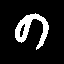

In [29]:
from PIL import Image

X_test = np.load("x_test.npz")["arr_0"]
Image.fromarray(X_test[1].astype(np.uint8))

In [14]:
import numpy as np

np.array([[1, 2, 3], [4, 5, 6]]).shape

(2, 3)

In [16]:
import torch

a = torch.Tensor([0, 0, 1, 0])
b = torch.Tensor([1, 0])
a == b

RuntimeError: The size of tensor a (4) must match the size of tensor b (2) at non-singleton dimension 0